# What is a Diversion?

## Background

With the rise of the Black Lives Matter movement, and the subsequent scrutiny of policing institutions, there have been renewed efforts to find alternatives to traditional law enforcement. During this time period, the Cahoots model garnered an unprecedented level of national attention. Cahoots has been held up as an example of a potential alternative to many law enforcement functions. However, the numbers are somewhat in dispute regarding the scope and scalability of the Cahoots model. Various media outlets reported that Cahoots was handling 17-20% of dispatched calls.  **(Source)**  

However, in 2021, the Eugene Police Department(EPD) published a response paper claiming that the true numbers were much lower at 3-8%. **(Source)** This paper seeks to replicate the EPD's findings, evaluate the validity of their methodological assumptions, and arrive at a data driven conception of the diversion rate. The research question motivating my analysis is RQ10: What proportion of calls are diverted from police to CAHOOTS response? How has that proportion changed over time?

Cahoots provides services that the police do not, and police have many duties that do not overlap with the mission of Cahoots. Simply looking at the total proportion of calls does not tell the full story. By examining the diversion rate we can further ascertain the viability of the Cahoots model to replace many types of police interaction. 


## Data

The data we will be using comes two sources. The first is computer aided dispatch (CAD) records from 2016-2021 for the Eugene area. This was obtained via public records request. Our second source of data will be the 2021 response paper published by the EPD. **(Source)**

### CAD DATA

- **Source:**  Obtained through a public records request from the City of Eugene Police Department.
- **Observations:** Individual calls for service recorded by the CAD system.
- **Variables:** Call creation time, incident type, responding unit, disposition, zip code, IncidentNumber, Call_First_Dispatched_Time, Call_First_On_Scene, Call_Cleared,	IsPrimary, PrimaryUnitCallSign, RespondingUnitCallSign
- **Strengths:**  Comprehensive record of calls, allows for analysis of response patterns over time.
- **Limitations:**  There could be Cahoots call signs we are unaware of, may not capture all community interactions, incident types overly granular, potential for data entry errors. 

While this data has a single source, this project creates two separate datasets based off of the CAD data. These datasets serve two separate purposes:

**Dataset 1: The Replication Data**  (data_prep.ipynb)

The purpose of this dataset is to approximate the data used in the 2021 EPD paper as closely as possible. Based on the replications of the EPD diversion methodology we will use this dataset to rerun our calculations under different assumptions. It is important to note that since EPD has access to more specific features, the numbers cannot match 1:1. For example, the EPD seems to access to a very easy way to pull only Cahoots calls while we have to clean the call signs manually. I have made a separate public records request to address this, but for now, we will work with the tools available. 

How this dataset was made:

   - Imports necessary libraries 
   - Loads CAD data from `data/call_data_from_CAD.csv`.
   - converts call times to datetime objects and adds a year col
   - Standardizes Cahoots identifiers in call sign columns.
   - Creates a binary column `Cahoots_Related` indicating Cahoots involvement.
   - Drops irrelevant columns 
   - Sorts data by `Call_Created_Time`. 
   - Creates a 2021 only dataset for exclusive use in replication
   - Saves both datasets to `data/cleaned_data/`.


In [1]:
import pandas as pd
import numpy as np
data = {
    "IncidentNumber": [
        "OR-2021-01-01-21000001", "OR-2021-01-02-21000002", "OR-2021-01-03-21000003", 
        "OR-2021-01-04-21000004", "OR-2021-01-05-21000005"
    ],
    "Call_Created_Time": [
        "2021-01-01 00:00:58", "2021-01-02 14:15:23", "2021-01-03 09:30:45", 
        "2021-01-04 18:45:12", "2021-01-05 11:22:33"
    ],
    "Call_First_Dispatched_Time": [
        "2021-01-01 00:22:41", "2021-01-02 14:25:11", "2021-01-03 09:45:00", 
        "2021-01-04 18:50:30", "2021-01-05 11:30:45"
    ],
    "Call_First_On_Scene": [
        pd.NaT, "2021-01-02 14:30:00", "2021-01-03 09:50:00", 
        pd.NaT, "2021-01-05 11:40:00"
    ],
    "Call_Cleared": [
        "2021-01-01 00:22:47", "2021-01-02 15:00:00", "2021-01-03 10:15:00", 
        "2021-01-04 19:00:00", "2021-01-05 12:00:00"
    ],

    "IsPrimary": [1, 1, 1, 1, 1],
    "PrimaryUnitCallSign": ["CAHOOTS", "6E32", "6E33", "6E34", "CAHOOTS"],
    "RespondingUnitCallSign": ["CAHOOTS", "6E32", "CAHOOTS", "6E34", "CAHOOTS"],
    "Unit_Dispatched_Time": [
        "2021-01-01 00:22:41", "2021-01-02 14:25:11", "2021-01-03 09:45:00", 
        "2021-01-04 18:50:30", "2021-01-05 11:30:45"
    ],
    "Unit_OnScene_Time": [
        np.nan, "2021-01-02 14:30:00", "2021-01-03 09:50:00", 
        np.nan, "2021-01-05 11:40:00"
    ],
    "Unit_Cleared_Time": [
        "2021-01-01 00:22:47", "2021-01-02 15:00:00", "2021-01-03 10:15:00", 
        "2021-01-04 19:00:00", "2021-01-05 12:00:00"
    ],
    "Cahoots_Related": [
        1, 0, 1, 0, 1
    ]
}

df = pd.DataFrame(data)
df

,IncidentNumber,Call_Created_Time,Call_First_Dispatched_Time,Call_First_On_Scene,Call_Cleared,IsPrimary,PrimaryUnitCallSign,RespondingUnitCallSign,Unit_Dispatched_Time,Unit_OnScene_Time,Unit_Cleared_Time,Cahoots_Related
0,OR-2021-01-01-21000001,2021-01-01 00:00:58,2021-01-01 00:22:41,NaT,2021-01-01 00:22:47,1,CAHOOTS,CAHOOTS,2021-01-01 00:22:41,NaN,2021-01-01 00:22:47,1
1,OR-2021-01-02-21000002,2021-01-02 14:15:23,2021-01-02 14:25:11,2021-01-02 14:30:00,2021-01-02 15:00:00,1,6E32,6E32,2021-01-02 14:25:11,2021-01-02 14:30:00,2021-01-02 15:00:00,0
2,OR-2021-01-03-21000003,2021-01-03 09:30:45,2021-01-03 09:45:00,2021-01-03 09:50:00,2021-01-03 10:15:00,1,6E33,CAHOOTS,2021-01-03 09:45:00,2021-01-03 09:50:00,2021-01-03 10:15:00,1
3,OR-2021-01-04-21000004,2021-01-04 18:45:12,2021-01-04 18:50:30,NaT,2021-01-04 19:00:00,1,6E34,6E34,2021-01-04 18:50:30,NaN,2021-01-04 19:00:00,0
4,OR-2021-01-05-21000005,2021-01-05 11:22:33,2021-01-05 11:30:45,2021-01-05 11:40:00,2021-01-05 12:00:00,1,CAHOOTS,CAHOOTS,2021-01-05 11:30:45,2021-01-05 11:40:00,2021-01-05 12:00:00,1


**Dataset 2: Diversions Data** (data_prep.ipynb)

The purpose of this dataset is to calculate a novel conception of diversion rates based on call types of overlapping mandate. Since the EPD calculations do not remove any call types that fall outside of the Cahoots mission, we explore the results of only considering areas of substantial overlap. 

How this dataset was made:

   - Identifies incident types and dispositions exclusively handled by either Cahoots or police.
   - Filters the cleaned CAD data to include only shared incident and disposition types.
   - Calculates the proportion of Cahoots and police involvement for each incident type.
   - **Computes a composite score for each incident type to identify "substantial" incident types, where there is significant overlap in response between both Cahoots and Police.** This is done using the following steps:
     - **Calculate the Harmonic Mean of Proportions:** The harmonic mean is used because it is sensitive to situations where either Cahoots or police handle a very low proportion of calls for a specific type. This highlights types where there is potential for greater diversion to Cahoots.
     - **Scale Call Counts:** To prevent incident types with very high call volumes from dominating the score, the raw call counts for both Cahoots and police are scaled with a log transform.
     - **Combine Harmonic Mean and Scaled Counts:** The harmonic mean proportion is multiplied by the sum of the scaled Cahoots and police call counts to create the final composite score.
   - **Normalize Composite Scores:**  Z-score normalization is applied to the composite scores to standardize them and allow for comparisons across different incident types.
   - **Identify Substantial Incident Types:** Incident types with a normalized composite score greater than 0.5 are considered substantial, indicating significant shared responsibility between Cahoots and police. 
   - Creates a filtered CAD dataset containing only the substantial incident types.
   - Saves the filtered CAD data to `"data/cleaned_data/cleaned_CAD_diversions.csv"`.

## Methods

**Replicating the EPD Paper**

We will begin by replicating the EPD 2021 paper with their exact methodology and numbers. The EPD paper begins by creating several data tables based on different assumptions. These tables include a breakdown of incident type count and percentage of total calls. Based on these tables, the EPD paper calculates 7 different diversion rates, however, they conclude that only 2 of these rates are a valid approach to calculating diversion. These two rates which are the 3% - 8% estimates, will be the majority of our focus, however, I still include all mentioned diversion rates to track overlap in data filtering assumptions. While we can be certain our formulas are correct based on exact values from the paper, the EPD has data they declined to provide us which makes applying the exact data filters for every calculation impossible. While we do not have access to the exact features that the EPD has, I have identified several proxies within the data that allow us to come very close to the EPD filters. For the data filter involved in getting the 3% - 8% figures, we have nearly complete overlap when accounting for an EPD data error that will be explained in the results section. After accounting for this error, our dispatch dataset only differs from the paper by 4 total calls. The exact data filters will be shown in the replication results section.

| Step                                         | Method                                                            | Resources             | Input                        | Output                                                                  |
|----------------------------------------------|-------------------------------------------------------------------|-----------------------|------------------------------|-------------------------------------------------------------------------|
| Extract numbers from EPD paper               | Manually find and record the numbers from the EPD tables | `Python` | EPD paper     | All needed numbers recorded as variables                    |
| Derive formulas for each diversion rate      | Follow the stated methodology and reverse engineer where methods are missing           | `Python`   | Raw Numbers | The formula for each diversion rate              |
| Rerun all EPD calculations                   | Use derived formulas to recalculate rates and verify.              | `Python`    | Raw Numbers  | Recalculated diversion rates to verify against published results.       |
| Run `police_diversion_methodology.py`        | Execute script to apply police methodology on dataset.             | `Python`, `Pandas`              | `cleaned_CAD_DATA_2021`, welfare_prop        | Dictionary of Diversion Rate results and datasets `datasets_and_results`                    |
| Compare results to confirm validity          | Compare original results with recalculated and script results.      | `Python`, `Pandas`      | `datasets_and_results`['results']      | All diversion rates from the paper calculated on real data            |
| Generate Figures 1-5 from the EPD paper      | Use the data to generate the data tables from the paper         | `Python`, `Pandas` | `datasets_and_results`     | Figures 1-5 as specified in the EPD paper, recreated for comparison.    |


**The Natural Experiment**

The Eugene Police Department (EPD) claims that 74% of "Check Welfare" calls are eligible for diversion by CAHOOTS. This figure, derived from a 2019 analysis of 200 calls, lacks transparency in its methodology and relies solely on the opinions of an unspecified number of dispatchers, raising concerns about its reliability.

While it's impossible to definitively determine the impact of CAHOOTS' absence, we can analyze the program's expansion in 2017. Before then, calls received between the hours 5am-10am fell under the EPD's jurisdiction and, theoretically, were eligible for diversion. If the 74% figure holds true, we should see a significant increase in dispatched calls for non-divertible incident types between 2016 and 2017, after CAHOOTS expanded its service hours. 

Comparing the ratio of calls between 2016 and 2017 for each incident type can provide a more objective basis for adjusting the estimated proportion of calls eligible for diversion. This approach minimizes reliance on subjective assessments and offers a more data-driven perspective on the true proportion of divertible calls. Future research could establish a more robust baseline with access to data going back farther than 2016. 


| Step                                         | Method                                                            | Resources             | Input                        | Output                                                                  |
|----------------------------------------------|-------------------------------------------------------------------|-----------------------|------------------------------|-------------------------------------------------------------------------|
| Calculate the proportion of divertible welfare checks              | use `calculate_prop` to determine the proportion of divertible welfare checks | `Python`, `Pandas` | data_2016, data_2017, incident    | proportion of divertible welfare checks                   |
| Re-run `police_diversion_methodology.py`     | Recalculate diversion rates, changing only the welfare check adjustment          | `Python`, `Pandas`   | cleaned_data, welfare_prop | Adjusted Diversion Rates            |
| Calculate divertible proportion for other call types       | Use `calculate_prop` to determine divertible proportions              | `Python`, `Pandas`    | data_2016, data_2017, incidents | Divertible proportion of each call type    |
| Re-Run `police_diversion_methodology.py`        | Recalculate diversion rates with proportion adjustments           | `Python`, `Pandas`              | cleaned_data, incident scalers         | True Diversion Rate                  |
| Calculate Diversions by year        | Run `police_diversion_methodology.py` for each year in the data     | `Python`, `Pandas`      | `CAD_data_cleaned`     | Dictionary of diversions by year       |
| Plot Diversions by Year      | Run `create_diversion_rate_chart`       | `Python`, `Pandas`,  `matplotlib` |  `diversion_rates_by_year`, rate_key, low_estimate_key    | Stacked barchart showing diversion rates by year   |
| Create Tree Plots     | Run `tree.py` for EPD and Cahoots      | `Python`, `Pandas`, `matplotlib`, `hashlib`, `squarify` |  data, top_n, labels, color_list, min label area   | Tree plot of Incident types, EPD VS Cahoots   |
| Plot diversions by Hourly call volume   | Apply the high estimate formula by hour     | `Python`, `Pandas`, `matplotlib`|  diversion data  | Diversions by hourly Call volume  |

**Diversions of Overlapping Mandate**

We have examined diversion rates under the EPD framework, however, this does not tell the full story. If our sole interest is the exact call volume savings Cahoots provides to the police, our previous analysis does the job. However, I do not think this tells the full story. While it is true that Cahoots provides many services the police do not, there are also many call types we would never expect Cahoots to involved in. Since I am not aware any push to have Cahoots vans pull over reckless drivers or respond to armed robberies, including these in the denominator of our diversion rate seems to miss the point. Thus, for the purposes of this analysis, we will only consider incident types that both Cahoots and Police handle above a certain threshold. The incident types above this threshold will be considered areas of **Overlapping Mandate** and all other calls with different incident types will be removed from both police and cahoots. It it important to note that these numbers are not directly comparable to our rates above as we are calculating the diversion rate of overlapping mandate rather than the overall diversion rate. Both numbers are useful, they just describe different things. 

| Step                                         | Method                                                           | Resources             | Input                       | Output                                                                  |
|-----------------------------------------------|-----------------------------------------------------------------|-----------------------|----------------------------|--------------------------------------------------------------------------|
| Identify "Substantial" Overlapping Incidents | Filter CAD data to "substantial" incident types using composite scores. | `Python`, `pandas`              | Cleaned CAD Diversions dataset | Filtered dataset with incident types suitable for potential diversion.        |
| Yearly Proportions (Overlapping Calls)      | Group calls by year and agency, calculate and plot proportions.     | `Python`, `pandas`, `matplotlib` | Filtered CAD dataset         | Stacked bar chart of yearly proportions for calls with overlapping mandates. |
| Top 5 Overlapping Incidents                | Identify the top 5 most frequent "substantial" incident types.        | `Python`, `pandas`, `matplotlib` | Filtered CAD dataset         | Bar chart showing proportion of calls by agency for the top 5 overlapping types. |
| Incident Type Visualization (Overlapping)     | Generate treemaps visualizing the distribution of these types.      | `Python`, `squarify`, `matplotlib` | Filtered CAD dataset         | Treemaps of incident types for each agency, focused on overlapping mandates. | 


## Results

### Part 1: Replication

The paper begins by examining 3 cross sections of the cahoots data: Cahoots associations, cahoots dispatched, and cahoots arrived. As their names imply, cahoots associations are any call that cahoots has some involvement in, cahoots dispatched includes calls where a Cahoots unit was actually dispatched, and cahoots arrived requires that the unit shows up on scene. These datasets are used to calculate what EPD calls the "Gross Diversion Rates," but the paper specifies that these are not reliable metrics because they include work that police would not generally do. 

Here are the exact formulas:

**Gross Diversion Rates**

| Rate | Formula | Description |
|---|---|---|
| **Diversion Rate 1a** |  $\frac{\text{CAHOOTS Associations}}{\text{Total Calls}}$  | This rate represents all instances where CAHOOTS was associated with a call, regardless of dispatch or arrival status. |
| **Diversion Rate 1b** | $\frac{\text{CAHOOTS Dispatched}}{\text{Total Calls}}$ | This rate considers calls where CAHOOTS was dispatched. |
| **Diversion Rate 1c** | $\frac{\text{CAHOOTS Only Arrived}}{\text{Total Calls}}$  | This rate considers all calls where CAHOOTS alone arrived at the scene. |



###  The Curious Case of Missing Call Types and Shifting Denominators

The EPD report goes on to present 4 more diversion rate calculations, each with its own set of assumptions and inconsistencies.
<br>


**Diversion Rates 2a and 2b: A Tale of Two Denominators**

The report claims the top 3 incident types handled by CAHOOTS – Assist Public, Check Welfare, and Transport – are not typical police calls. Based on this, diversion rates 2a and 2b are calculated by subtracting these call types from the total CAHOOTS call volume and assuming the remaining calls to be divertible (Remember this when we go into 3a and 3b)

* **Diversion Rate 2a:**  The report defines this as the ratio of (total arrived CAHOOTS calls minus the top 3 call types) to the total number of calls for service (CFS). However, it's unclear if the denominator also excludes the top 3 CAHOOTS call natures. 

The EPD report says the correct diversion rate here is 2%. Depending on how the denominator is calculated, the diversion rate fluctuates between 2.3% (without removing top 3 call types from the denominator) and 2.6% (with removal). This ambiguity raises concerns about the calculation's accuracy. Furthermore, comparing the subset of *arrived only* CAHOOTS calls to the total call volume, which includes calls that were never even dispatched, is methodologically flawed.

* **Diversion Rate 2b:** This calculation attempts to address the denominator issue but introduces further inconsistencies. 

>  "If we look only at dispatched calls for both agencies (68,427) and subtract out the removed CAHOOTS natures (11,667) we are left with 56,760 total dispatched CFS, of which 2,545 were handled by CAHOOTS, which would equate to ~4% divert rate of dispatched calls." (EPD Report)

Here, the numerator uses the count of *arrived* CAHOOTS calls (excluding the top 3 types), while the denominator considers total *dispatched* calls (adjusted for the top 3 CAHOOTS types). This mixing of dispatched and arrived data without justification renders the resulting 4% diversion rate meaningless.

We know that *arrived* CAHOOTS calls are being used here because the report also states:

> "However, as discussed when examining call natures, the top 3 CAHOOTS CFS natures: Assist Public (5,058), Check Welfare (5,022), and Transport (1,587) are not traditionally law enforcement calls and would likely not be dispatched to police." **(Source)

These values sum exactly to 11,667 and can be found in data table 5 of the EPD report which describes Arrived only Cahoots Calls. **(Source)

For some reason, we are using arrived only calls in the numerator and using total dispatched calls in the denominator while adjusting the denominator based on arrived only calls. This diversion rate does not have the benefit of ambiguity seen in diversion rate 2a since it describes the exact numbers used to reach the denominator.    
<br>
<br>

**Diversion Rates 3a and 3b: The Vanishing Call Types**  

These rates are the final EPD assessment of the true diversion rate. They assume welfare checks to be the only potentially divertible calls, relying on a 2019 analysis where an unspecified number of dispatchers categorized 74% of a 200-call sample as suitable for CAHOOTS. **(Source)

 Both 3a and 3b disregard all other call types, many of which were deemed as the only divertible calls in the 2a/2b calculations. The basis of 2a and 2b is that Check welfare, Transport, and Public Assists are not typically police calls so they should be excluded. However, all other call types were assumed to eligible for diversion in 2a/2b. 3a and 3b then make the argument that entirely excluding welfare calls is not fair, so they apply their 74% adjustment to the welfare check category. However, somewhere along the way we lost track of all those other divertible call types. This arbitrary exclusion lacks justification and contradicts the report's previous logic. 
 
 When you consider the other call types to be divertible, you get a range of 5% - 11%. This should have been the final range presented by the paper without clear justification to exclude the other call types. 


* **Diversion Rate 3a:** This calculates the diversion rate as the percentage of dispatched welfare checks (assumed to be 74% divertible) out of the total Calls. 
3a has similar methodological issues as seen in 2a, mixing total calls with dispatched calls.


* **Diversion Rate 3b:** Similar to 2b, this rate compares dispatched welfare checks (again, assuming 74% divertibility) to total dispatched calls. However, it does not seem to mix dispatch and arrivals in the same way which is good news for this estimate but makes the thought process around 2b mysterious. 
<br>
<br>

**Data Discrepancies**

The paper reports the number of dispatched welfare checks as 5,546 but data table 2 of the paper reports the number as 6,003. 5,546 shows up nowhere else in the paper so this seems to be based on outdated data. For the first calculations, I will assume the explicitly stated 5,546 valued. (More on this later)

**Adjusted Diversion Rates**

| Rate | Formula | Description |
|---|---|---|
| **Diversion Rate 2a** | $\frac{\text{CAHOOTS Only Arrived} - (\text{top 3 arrived Cahoots incidents})}{\text{Total Calls}}$  | Removes the total count of the 3 most common call types handled by Cahoots from the numerator. |
| **Diversion Rate 2b** | $\frac{\text{CAHOOTS Only Arrived} - (\text{top 3 arrived Cahoots incidents})}{\text{(Dispatched EPD and Cahoots) - (top 3 arrived Cahoots incidents)}}$  | Similar to Diversion Rate 4, but only considers calls that arrived on scene. |
| **Diversion Rate 3a (Low)** | $\frac{\text{(Dispatched Cahoots Welfare Calls) * 0.74}}{\text{Total Calls}}$ | Assumes that Welfare check is the only diverted call type and that 0.74 are diversions. |
| **Diversion Rate 3b (High)** | $\frac{\text{(Dispatched Cahoots Welfare Calls) * 0.74}}{\text{(All Dispatched calls) - (Dispatched Cahoots calls - adjusted wellfare checks)}}$  | Similar to Diversion Rate 6 (Low), but calculated using the adjusted total for dispatched calls. |

**Replication using extracted data**

In [2]:
# --- CAHOOTS Data ---
cahoots_total_assoc = 22055 

# dispatch
cahoots_dispatches = 18106
cahoots_dispatches_check_welfare = 5546 # 6003 is the value in the data table 
cahoots_dispatches_transport = 1803 
cahoots_dispatches_assist = 5788

# arrival
cahoots_arrivals_solo = 14212
cahoots_arrivals_assist_public = 5058
cahoots_arrivals_check_welfare = 5022
cahoots_arrivals_transport = 1587

# --- EPD Data ---
epd_total_calls = 109854 
epd_dispatches_and_cahoots = 68427

# Calculated EPD dispatch count (excluding cases with CAHOOTS)
epd_dispatches_solo = epd_dispatches_and_cahoots - cahoots_dispatches  

# 1. Gross Divert Rates 
diversion_rate_associations = (cahoots_total_assoc / epd_total_calls) * 100
diversion_rate_dispatches = (cahoots_dispatches / epd_total_calls) * 100
diversion_rate_cahoots_only_arrivals = (cahoots_arrivals_solo / epd_total_calls) * 100

# 2. Diversion Rate (Removing Top 3 Cahoots Calls)
diversion_rate_removing_centric_calls =  ((cahoots_arrivals_solo - cahoots_arrivals_assist_public - cahoots_arrivals_check_welfare - cahoots_arrivals_transport) / epd_total_calls) * 100

diversion_rate_removing_centric_calls_dispatch =  ((cahoots_arrivals_solo - cahoots_arrivals_assist_public - cahoots_arrivals_check_welfare - cahoots_arrivals_transport) / 
                                                   (epd_dispatches_and_cahoots - cahoots_arrivals_transport - cahoots_arrivals_check_welfare - cahoots_arrivals_assist_public)) * 100


# Diversion Rate welfare check adjusted (Low)
CHECK_WELFARE_EPD_PROBABILITY = 0.74 
estimated_epd_check_welfare = CHECK_WELFARE_EPD_PROBABILITY * cahoots_dispatches_check_welfare

diversion_rate_adjusted_all_calls = (estimated_epd_check_welfare / epd_total_calls) * 100

# Diversion Rate welfare check adjusted (High)
diversion_rate_adjusted_dispatched_calls_high = (estimated_epd_check_welfare / (epd_dispatches_and_cahoots - (cahoots_dispatches - estimated_epd_check_welfare))* 100 )

# --- Output ---
result_og = {
        "1a. Diversion Rate (Associations)": diversion_rate_associations,
        "1b. Diversion Rate (Dispatches)": diversion_rate_dispatches,
        "1c. Diversion Rate (CAHOOTS Only Arrivals)": diversion_rate_cahoots_only_arrivals,
        "2a. Diversion Rate (Removing CAHOOTS-Centric Calls)": diversion_rate_removing_centric_calls,
        "2b. Diversion Rate (Removing CAHOOTS-Centric Calls, Dispatch only)": diversion_rate_removing_centric_calls_dispatch,
        "3a. Diversion Rate (Adjusted for Check Welfare - All Calls)": diversion_rate_adjusted_all_calls,
        "3b. Diversion Rate (Adjusted for Check Welfare - Dispatched Calls)": diversion_rate_adjusted_dispatched_calls_high
    }
result_og

{'1a. Diversion Rate (Associations)': 20.076647186265404,
 '1b. Diversion Rate (Dispatches)': 16.48187594443534,
 '1c. Diversion Rate (CAHOOTS Only Arrivals)': 12.937171154441348,
 '2a. Diversion Rate (Removing CAHOOTS-Centric Calls)': 2.316711271323757,
 '2b. Diversion Rate (Removing CAHOOTS-Centric Calls, Dispatch only)': 4.4837914023960534,
 '3a. Diversion Rate (Adjusted for Check Welfare - All Calls)': 3.7359040180603347,
 '3b. Diversion Rate (Adjusted for Check Welfare - Dispatched Calls)': 7.540720227307136}

Despite the methodological errors in the EPD diversion rate calculations, we will still attempt to replicate them exactly. To do this on the real dataset, we will be using `police_diversion_methodology.py`. This gives us access to a function I wrote called `run_police_diversions` that applies the same formulas above to our data. It also allows for us the to change the assumed divertible proportions for various call types. 

In [3]:
import os
os.chdir('../')

In [4]:
from scripts.police_diversion_methodology import run_police_diversions
import pandas as pd

file_path = 'Data/cleaned_data/cleaned_CAD_data_2021_diversions.csv'
cleaned_data = pd.read_csv(file_path)

datetime_columns = ['Call_Created_Time', 'Call_First_Dispatched_Time', 'Call_First_On_Scene', 'Call_Cleared']
for col in datetime_columns:
    cleaned_data[col] = pd.to_datetime(cleaned_data[col], errors='coerce')
    
cleaned_data = cleaned_data.dropna(subset=['Call_Created_Time', 'Call_Source', 'InitialIncidentTypeDescription'])

**EPD Methodology Using the CAD Data**

In [5]:
datasets_and_results = run_police_diversions(cleaned_data, 0.74)
datasets_and_results['results']

{'1a. Diversion Rate (Associations)': 20.755246527966392,
 '1b. Diversion Rate (Dispatches)': 16.41045140963659,
 '1c. Diversion Rate (CAHOOTS Only Arrivals)': 13.431835877378816,
 '2a. Diversion Rate (Removing CAHOOTS-Centric Calls)': 2.580259655603238,
 '2b. Diversion Rate (Removing CAHOOTS-Centric Calls, Dispatch only)': 5.02929342838992,
 '3a. Diversion Rate (Adjusted for Check Welfare - All Calls)': 4.024462672243649,
 '3b. Diversion Rate (Adjusted for Check Welfare - Dispatched Calls)': 8.086088525349998}

**Difference in results, EPD paper vs CAD calculation**

In [6]:
difference = {key: round(datasets_and_results['results'].get(key, 0) - result_og[key], 2) for key in result_og}
difference

{'1a. Diversion Rate (Associations)': 0.68,
 '1b. Diversion Rate (Dispatches)': -0.07,
 '1c. Diversion Rate (CAHOOTS Only Arrivals)': 0.49,
 '2a. Diversion Rate (Removing CAHOOTS-Centric Calls)': 0.26,
 '2b. Diversion Rate (Removing CAHOOTS-Centric Calls, Dispatch only)': 0.55,
 '3a. Diversion Rate (Adjusted for Check Welfare - All Calls)': 0.29,
 '3b. Diversion Rate (Adjusted for Check Welfare - Dispatched Calls)': 0.55}

**Analyzing Discrepancies**

If we calculate the difference between the results we can see that all calculations are within a single percentage point. However, since 3a and 3b are the most important to get correct, I investigated them further. The difference between our results from the papers numbers and the real data for 3a and 3b initially seem to be on the higher side. However, if you recall the conflicting welfare check dispatch numbers, we see find something quite curious. When changing the number of dispatched welfare checks from the 5,546 reported in the EPD paper, to the 6003 present in the papers data table, the discrepancy basically disappears. The number from the real data is 6,007 which might indicate that the 5,546 was indeed outdated. This brings our initial calculation of 7.5% to 8.1% which more closely matches the 8% reported value in the paper. This leads me to believe that despite the incorrect value in the paper, the actual calculations for the high end estimate was done with the 6003 number. The low end estimate becomes more tricky because if we apply this same 6003 to the low end estimate we go from 3.8% to 4%. One possibility is that the low end estimate was calculated at a different time after more data came in. Perhaps The high end estimate was calculated using 6,003 and low end estimate was calculated using 5,546. Since the replications for diversion rates 3a and 3b are now within 0.03 percentage points we can confidently say that our function has successfully reproduced our methodology derived from the EPD paper. Future work could be done to investigate the small discrepancies in associations, and arrivals, but these do not impact the final range given by EPD so that will have to be another day. 

In [7]:
datasets_and_results['cahoots_dispatched']["InitialIncidentTypeDescription"].value_counts().reset_index().head(1)

,InitialIncidentTypeDescription,count
0,CHECK WELFARE,6007


**Re-run the numbers with the 6,003 from data table 2 of the EPD paper**

In [8]:
# Diversion Rate welfare check adjusted (Low)
CHECK_WELFARE_EPD_PROBABILITY = 0.74 
estimated_epd_check_welfare = CHECK_WELFARE_EPD_PROBABILITY * 6003
diversion_rate_adjusted_all_calls = (estimated_epd_check_welfare / epd_total_calls) * 100

# Diversion Rate welfare check adjusted (High)
diversion_rate_adjusted_dispatched_calls_high = (estimated_epd_check_welfare / (epd_dispatches_and_cahoots - (cahoots_dispatches - estimated_epd_check_welfare))* 100 )

result_og = {
        "1a. Diversion Rate (Associations)": diversion_rate_associations,
        "1b. Diversion Rate (Dispatches)": diversion_rate_dispatches,
        "1c. Diversion Rate (CAHOOTS Only Arrivals)": diversion_rate_cahoots_only_arrivals,
        "2a. Diversion Rate (Removing CAHOOTS-Centric Calls)": diversion_rate_removing_centric_calls,
        "2b. Diversion Rate (Removing CAHOOTS-Centric Calls, Dispatch only)": diversion_rate_removing_centric_calls_dispatch,
        "3a. Diversion Rate (Adjusted for Check Welfare - All Calls)": diversion_rate_adjusted_all_calls,
        "3b. Diversion Rate (Adjusted for Check Welfare - Dispatched Calls)": diversion_rate_adjusted_dispatched_calls_high
    }
result_og

{'1a. Diversion Rate (Associations)': 20.076647186265404,
 '1b. Diversion Rate (Dispatches)': 16.48187594443534,
 '1c. Diversion Rate (CAHOOTS Only Arrivals)': 12.937171154441348,
 '2a. Diversion Rate (Removing CAHOOTS-Centric Calls)': 2.316711271323757,
 '2b. Diversion Rate (Removing CAHOOTS-Centric Calls, Dispatch only)': 4.4837914023960534,
 '3a. Diversion Rate (Adjusted for Check Welfare - All Calls)': 4.043748975913485,
 '3b. Diversion Rate (Adjusted for Check Welfare - Dispatched Calls)': 8.111685178482931}

In [9]:
difference = {key: round(datasets_and_results['results'].get(key, 0) - result_og[key], 2) for key in result_og}
difference

{'1a. Diversion Rate (Associations)': 0.68,
 '1b. Diversion Rate (Dispatches)': -0.07,
 '1c. Diversion Rate (CAHOOTS Only Arrivals)': 0.49,
 '2a. Diversion Rate (Removing CAHOOTS-Centric Calls)': 0.26,
 '2b. Diversion Rate (Removing CAHOOTS-Centric Calls, Dispatch only)': 0.55,
 '3a. Diversion Rate (Adjusted for Check Welfare - All Calls)': -0.02,
 '3b. Diversion Rate (Adjusted for Check Welfare - Dispatched Calls)': -0.03}

**Replicated Data Tables from the EPD Paper**

For easy data comparison, we replicate the data tables from the EPD paper using the CAD data. Each table has the same label as seen in the paper. Fig 3, 6, and 7 are not included as they are not used for calculating any of the diversion rates. 

In [10]:
fig = 0
for i in list(datasets_and_results.keys())[:-1]:
    fig += 1
    if fig == 3:  # Check if figure number is 3
        fig += 1  # Skip figure number 3 by incrementing again

    # Create a DataFrame from the value counts
    count_series = datasets_and_results[i]['InitialIncidentTypeDescription'].value_counts()
    top_10 = count_series.head(10)
    other_count = count_series[10:].sum()
    
    # Create DataFrame for top 10
    df = pd.DataFrame(top_10).reset_index()
    df.columns = ['Incident Type', 'Count']
    
    # Create 'Other' row
    other_row = pd.DataFrame([{'Incident Type': 'Other', 'Count': other_count}])
    
    # Concatenate the top 10 DataFrame with the 'Other' row
    df = pd.concat([df, other_row], ignore_index=True)
    
    # Calculate the percentage of total calls
    total_calls = count_series.sum()
    df['Percentage of Total Calls'] = ((df['Count'] / total_calls) * 100).round(2).astype(str) + '%'
    
    # Append a row for the total count
    total_row = pd.DataFrame([{'Incident Type': 'Total', 'Count': total_calls}])
    df = pd.concat([df, total_row], ignore_index=True)
    
    # Check if it is not the last key to display the DataFrame
    if i != list(datasets_and_results.keys())[-2]:
        print(f"Figure {fig}: {i}")
        display(df)


Figure 1: cahoots_associations


,Incident Type,Count,Percentage of Total Calls
0,CHECK WELFARE,7615,33.22%
1,ASSIST PUBLIC- POLICE,7330,31.97%
2,TRANSPORT,2352,10.26%
3,SUICIDAL SUBJECT,1935,8.44%
4,DISORDERLY SUBJECT,543,2.37%
5,TRAFFIC HAZARD,444,1.94%
6,DISPUTE,328,1.43%
7,INTOXICATED SUBJECT,284,1.24%
8,CRIMINAL TRESPASS,278,1.21%
9,ASSIST FIRE DEPARTMENT,240,1.05%


Figure 2: cahoots_dispatched


,Incident Type,Count,Percentage of Total Calls
0,CHECK WELFARE,6007,33.14%
1,ASSIST PUBLIC- POLICE,5792,31.95%
2,TRANSPORT,1808,9.97%
3,SUICIDAL SUBJECT,1571,8.67%
4,DISORDERLY SUBJECT,457,2.52%
5,TRAFFIC HAZARD,372,2.05%
6,DISPUTE,256,1.41%
7,CRIMINAL TRESPASS,231,1.27%
8,INTOXICATED SUBJECT,219,1.21%
9,FOUND SYRINGE,192,1.06%


Figure 4: cahoots_only_associations


,Incident Type,Count,Percentage of Total Calls
0,ASSIST PUBLIC- POLICE,5715,35.02%
1,CHECK WELFARE,5708,34.98%
2,TRANSPORT,1788,10.96%
3,SUICIDAL SUBJECT,1301,7.97%
4,TRAFFIC HAZARD,329,2.02%
5,DISORDERLY SUBJECT,240,1.47%
6,INTOXICATED SUBJECT,206,1.26%
7,FOUND SYRINGE,191,1.17%
8,ASSIST FIRE DEPARTMENT,178,1.09%
9,DISORIENTED SUBJECT,132,0.81%


Figure 5: cahoots_only_arrived


,Incident Type,Count,Percentage of Total Calls
0,CHECK WELFARE,5222,35.2%
1,ASSIST PUBLIC- POLICE,5158,34.77%
2,TRANSPORT,1606,10.83%
3,SUICIDAL SUBJECT,1210,8.16%
4,TRAFFIC HAZARD,307,2.07%
5,DISORDERLY SUBJECT,218,1.47%
6,INTOXICATED SUBJECT,187,1.26%
7,ASSIST FIRE DEPARTMENT,163,1.1%
8,FOUND SYRINGE,160,1.08%
9,DISORIENTED SUBJECT,124,0.84%


### Part 2: Running The Natural Experiment

Our analysis successfully replicates the EPD's methodology, achieving a high degree of accuracy for their reported 3%-8% diversion rate range. However, we haven't yet fully scrutinized the assumed 74% divertible proportion for welfare checks. 

Instead of taking this figure at face value, we can leverage a data-driven approach to estimate police call volume in CAHOOTS' absence. Recall that CAHOOTS expanded its service hours to include 5am - 10am on January 1, 2017. This period offers a natural experiment: all calls during these hours before 2017 were inherently divertible, as they were handled solely by police. 

If the EPD's assertion about a significant portion of welfare checks being non-divertible holds true, we should observe a substantial increase in total welfare checks during these hours from 2016 to 2017. 


In [11]:
from scripts.natural_exp import calculate_prop, create_diversion_rate_chart

CAD_data = pd.read_csv("data/cleaned_data/cleaned_CAD_data_diversions.csv")
CAD_data["Call_Created_Time"] = pd.to_datetime(CAD_data['Call_Created_Time'], errors='coerce')
CAD_data["year"] = CAD_data["Call_Created_Time"].dt.year
CAD_data["Call_First_Dispatched_Time"] = pd.to_datetime(CAD_data['Call_First_Dispatched_Time'], errors='coerce')
CAD_data = CAD_data[CAD_data['Call_Source'] != 'SELF'].copy()
CAD_data = CAD_data.dropna(subset=['Call_Created_Time', 'Call_Source', 'InitialIncidentTypeDescription'])

data_2016 = CAD_data[(CAD_data["Call_First_Dispatched_Time"].dt.year == 2016) & 
                         (CAD_data["Call_First_Dispatched_Time"].dt.hour >= 5) & 
                         (CAD_data["Call_First_Dispatched_Time"].dt.hour < 10)].copy()

data_2017 = CAD_data[(CAD_data["Call_First_Dispatched_Time"].dt.year == 2017) & 
                         (CAD_data["Call_First_Dispatched_Time"].dt.hour >= 5) & 
                         (CAD_data["Call_First_Dispatched_Time"].dt.hour < 10)].copy()

data_2016.dropna(subset=['Call_First_Dispatched_Time'], inplace=True)
data_2017.dropna(subset=['Call_First_Dispatched_Time'], inplace=True)

Filtering for the appropriate time periods we find 1310 welfare checks in 2016 and 1361 welfare checks in 2017, representing an increase of ~4%. Despite this modest increase, Cahoots went on to handle 50% of the calls during this time period. Applying our `calculate_prop` function we find an estimated ~96% of welfare checks to be eligible for diversion. 

In [12]:
welfare_prop = calculate_prop(data_2016, data_2017, ["CHECK WELFARE"])["CHECK WELFARE"]
welfare_prop

2016: {'CHECK WELFARE': 1310}
2017: {'CHECK WELFARE': 1361}


0.9625275532696547

**Percent of Welfare Checks Handled by Cahoots 2017**

In [33]:
(data_2017[data_2017["Cahoots_related"] == 1]["InitialIncidentTypeDescription"].value_counts().to_list()[0] / data_2017["InitialIncidentTypeDescription"].value_counts().to_list()[1]) * 100

49.62762356127285

For the Check welfare category, we find very little change in call volume from 2016 to 2017 during the hours of 5am - 10am. This indicates that the vast majority of Check Welfare calls are eligible for diversion, and that the 0.74 figure is likely an significant undercount.Adjusting 0.74 to 0.96, and Keeping all else equal, let's rerun the diversion rates:

In [13]:
welfare_corrected_results = run_police_diversions(cleaned_data, welfare_prop, 0, 0)
welfare_corrected_results['results']

{'1a. Diversion Rate (Associations)': 20.755246527966392,
 '1b. Diversion Rate (Dispatches)': 16.41045140963659,
 '1c. Diversion Rate (CAHOOTS Only Arrivals)': 13.431835877378816,
 '2a. Diversion Rate (Removing CAHOOTS-Centric Calls)': 2.580259655603238,
 '2b. Diversion Rate (Removing CAHOOTS-Centric Calls, Dispatch only)': 5.02929342838992,
 '3a. Diversion Rate (Adjusted for Check Welfare - All Calls)': 5.234670552891535,
 '3b. Diversion Rate (Adjusted for Check Welfare - Dispatched Calls)': 10.268003855748532}

With no other adjustments, our diversion rate is now somewhere between 5% - 10%. This still does not capture what even the EPD says they set out the measure. Recall that this number still assumes all other call types to be 0. In reality, check welfare is far from the only divertable call type. Let's now calculate the divertible proportions for 3 other cahoots incident types and consider them in our calculations. 

In [14]:
incidents = ["CHECK WELFARE", "TRANSPORT", "ASSIST PUBLIC- POLICE", "SUICIDAL SUBJECT"]
correct_props = calculate_prop(data_2016, data_2017, incidents)
correct_props

2016: {'CHECK WELFARE': 1310, 'SUICIDAL SUBJECT': 253, 'ASSIST PUBLIC- POLICE': 134, 'TRANSPORT': 87}
2017: {'CHECK WELFARE': 1361, 'TRANSPORT': 585, 'ASSIST PUBLIC- POLICE': 583, 'SUICIDAL SUBJECT': 323}


{'CHECK WELFARE': 0.9625275532696547,
 'SUICIDAL SUBJECT': 0.7832817337461301,
 'ASSIST PUBLIC- POLICE': 0.22984562607204118,
 'TRANSPORT': 0.14871794871794872}

We can see that welfare checks are indeed the most divertible call type, however, the others are far from 0. Let's now consider these missing call types in our diversion rate calculations, holding all else equal. Note that only diversion 3a and 3b should be changing with these adjustments as diverison rates 1-2 are not impacted by the proportional analysis used by the EPD. 

In [15]:
welfare_prop = correct_props["CHECK WELFARE"]
transport_prop = correct_props["TRANSPORT"]
assist_prop = correct_props["ASSIST PUBLIC- POLICE"]
suicide_prop = correct_props["SUICIDAL SUBJECT"]

top_3_corrected_results = run_police_diversions(cleaned_data, welfare_prop, transport_prop, assist_prop, suicide_prop)
top_3_corrected_results['results']

{'1a. Diversion Rate (Associations)': 20.755246527966392,
 '1b. Diversion Rate (Dispatches)': 16.41045140963659,
 '1c. Diversion Rate (CAHOOTS Only Arrivals)': 13.431835877378816,
 '2a. Diversion Rate (Removing CAHOOTS-Centric Calls)': 2.580259655603238,
 '2b. Diversion Rate (Removing CAHOOTS-Centric Calls, Dispatch only)': 5.02929342838992,
 '3a. Diversion Rate (Adjusted for Check Welfare - All Calls)': 7.797441952031886,
 '3b. Diversion Rate (Adjusted for Check Welfare - Dispatched Calls)': 14.562903478797923}

With these adjustments our range is now 8% - 15%. Our low end estimation has now caught up with the EPD's original max estimate suggesting that the proportion of divertable call types is much higher than originally claimed. This range is still a low ball estimate in many respects but still serves as a useful baseline diversion rate. 

In [16]:
CAD_data_filter = CAD_data[(CAD_data["Call_Created_Time"].dt.year >= 2017) & (CAD_data["Call_Created_Time"].dt.year <= 2021)]
diversion_rates_by_year = {}
for year in range(2017, 2022):  # Loop through years 2017 to 2021
    # Filter data for the current year
    yearly_data = CAD_data[CAD_data["Call_Created_Time"].dt.year == year]
    
    # Calculate diversion rates for the filtered yearly data
    yearly_rates = run_police_diversions(yearly_data, welfare_prop, transport_prop, assist_prop, suicide_prop)
    
    # Store the results in the dictionary
    diversion_rates_by_year[year] = yearly_rates['results']

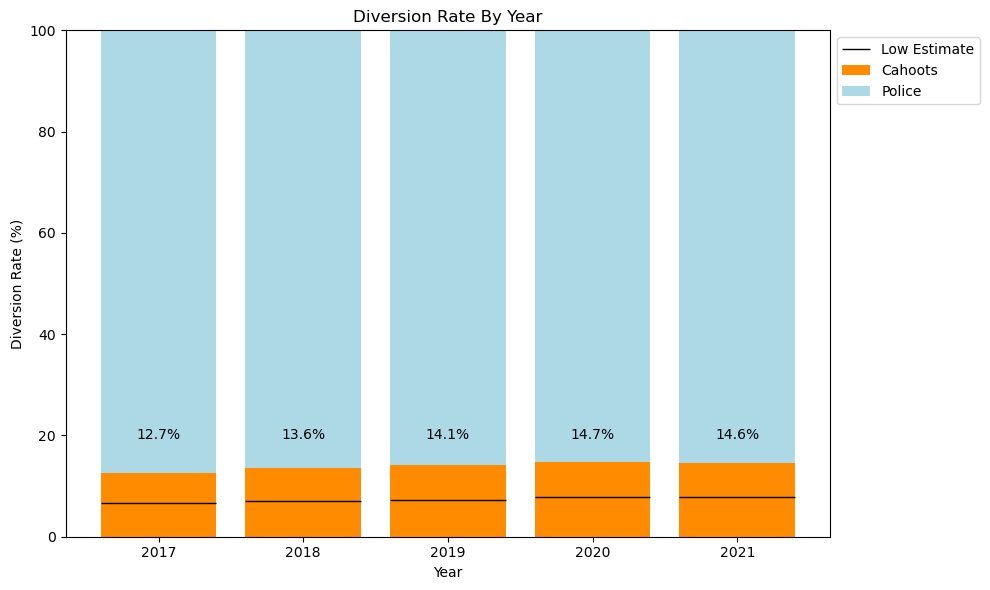

In [17]:
create_diversion_rate_chart(
    diversion_rates_by_year,
    rate_key='3b. Diversion Rate (Adjusted for Check Welfare - Dispatched Calls)',
    low_estimate_key='3a. Diversion Rate (Adjusted for Check Welfare - All Calls)',
    title='Diversion Rate By Year',
    rate_label='Cahoots',
    low_estimate_label='Low Estimate' 
)

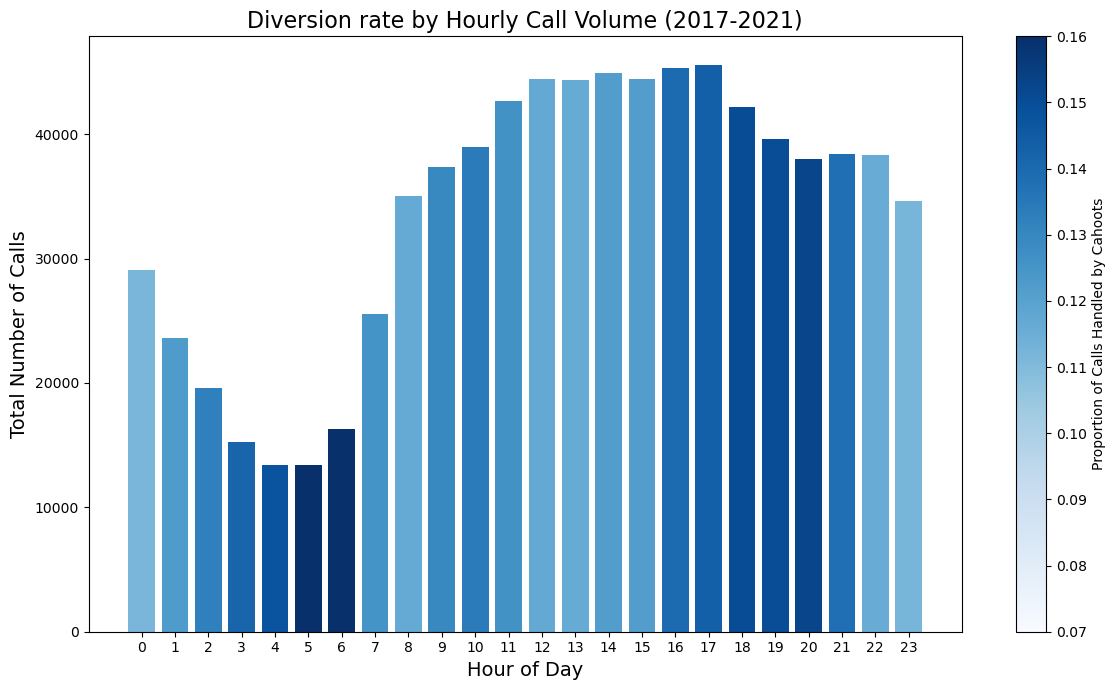

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract the hour from 'Call_Created_Time'
CAD_data_filter = CAD_data_filter.copy()
CAD_data_filter['Hour'] = CAD_data_filter['Call_Created_Time'].dt.hour

# Calculate the number of calls handled by police and Cahoots by hour
call_volume_by_hour = CAD_data_filter.groupby(['Hour', 'Cahoots_related']).size().unstack(fill_value=0)
call_volume_by_hour.columns = ['Police', 'Cahoots']

# Calculate the proportions
call_volume_by_hour['Total'] = call_volume_by_hour.sum(axis=1)
call_volume_by_hour['Cahoots_Proportion'] = call_volume_by_hour['Cahoots'] / call_volume_by_hour['Total']
call_volume_by_hour['Police_Proportion'] = call_volume_by_hour['Police'] / call_volume_by_hour['Total']

# Plot the bar chart with improved color intensity
plt.figure(figsize=(12, 7))
norm = plt.Normalize(0.07, 0.16)
colors = plt.cm.Blues(norm(call_volume_by_hour['Cahoots_Proportion']))

bars = plt.bar(call_volume_by_hour.index, call_volume_by_hour['Total'], color=colors)

# Create a ScalarMappable and use the axes from the plot for the colorbar
sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
sm.set_array([])

# Use the same axes for the colorbar
ax = plt.gca()  # Get current axes
cbar = plt.colorbar(sm, ax=ax)  # Pass the axes explicitly
cbar.set_label('Proportion of Calls Handled by Cahoots')

plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Total Number of Calls', fontsize=14)
plt.title('Diversion rate by Hourly Call Volume (2017-2021)', fontsize=16)
plt.xticks(range(0, 24))
plt.tight_layout()

## TODO: Analysis and conclusion

### Part 3: Diversions of Overlapping Mandate

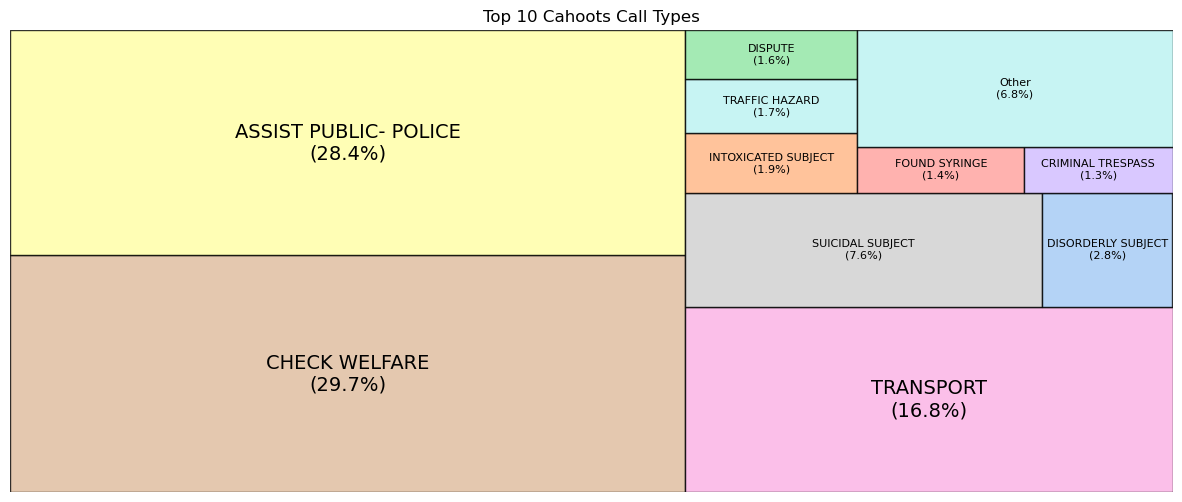

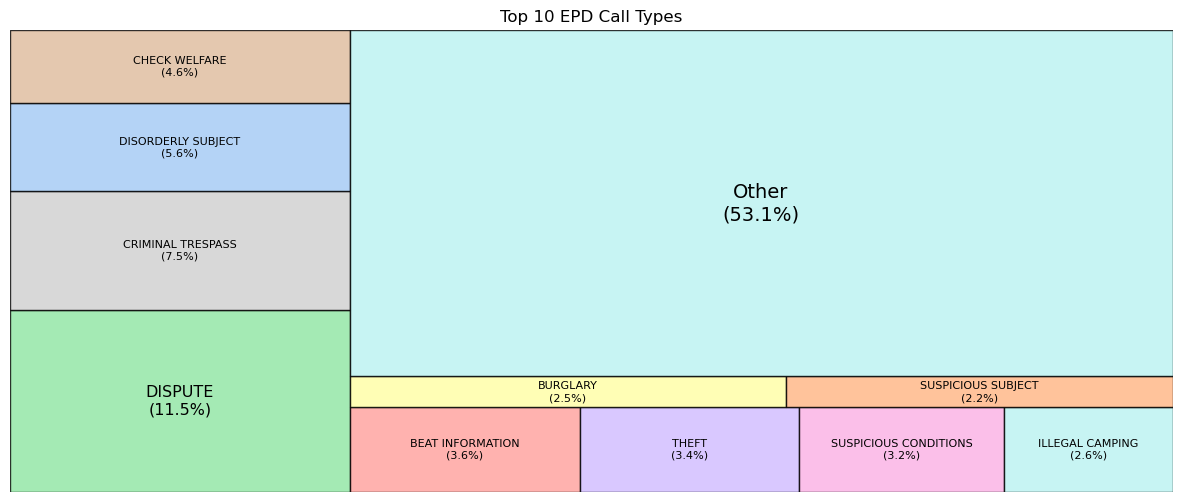

In [39]:
import matplotlib 
import matplotlib.cm as cm
from scripts.tree import create_treemap
import seaborn as sns

# use sns color palette
sns_colors = sns.color_palette("pastel")

# Use matplot colors
plt_colormap = matplotlib.colormaps['tab20b']
plt_colormap = [matplotlib.colors.rgb2hex(plt_colormap(i)) for i in range(plt_colormap.N)]

# Use custom colors
custom_colors = [
    '#009E73',  # Green
    '#E69F00',  # Gold/Orange
    '#56B4E9',  # Light Blue
    '#D55E00',  # Red-Orange/Brown
    '#CC79A7',  # Pink/Purple
    '#F0E442',  # Yellow (use sparingly)
    '#999999',  # Gray
    '#363737',  # Blackish
    '#FDB462',  # Light Orange
    '#B3DE69',  # Light Green
    '#BC80BD',  # Purple
    '#FB8072',  # Salmon
    '#1F78B4',  # Dark Blue
]

cahoots_data = CAD_data_filter[CAD_data_filter['Cahoots_related'] == 1]
police_data = CAD_data_filter[CAD_data_filter['Cahoots_related'] == 0]

create_treemap(cahoots_data, 'Top 10 Cahoots Call Types', top_n=10, group_others=True, max_legend_entries=10, show_labels=True, color_list=sns_colors, min_label_area_ratio=0.01)
create_treemap(police_data, 'Top 10 EPD Call Types', top_n=10, group_others=True, max_legend_entries=10, show_labels=True, color_list=sns_colors, min_label_area_ratio=0.012)

From the plot above we can see that EPD and Cahoots have a far range of different range of responsibilities. The top 10 call types for Cahoots Make up the vast majority of Cahoots activity whereas the top 10 call types for the EPD are less than half of their total call volume.  Now that we have examined diversions through the lens of direct impact on total EPD call volume, we will turn our attention to calls that could reasonably be expected to be handled by either Cahoots or police. We begin by removing incident types that have zero overlap between Police and Cahoots. This is the simplest case since if Cahoots has never responded to a call type it is clearly outside of their mandate. Determining substantial areas of overlap is trickier. We want to account for total numbers of calls since there are call types that have been dealt with by both Cahoots and EPD 3 times in the last 5 years. If we only consider the overlap of the categories, incidents such as this with 6 total calls would be included over incidents with a less even split but with far more total calls handled by each agency. 

However, this also risks simply having our composite score dominated by the highest call count incidents so we apply a log transformation to lessen the impact of raw call count. To make sure the composite scores are directly comparable across incident type we apply Z-Score Normalization to standardize the scale. The idea is to balance raw call count with proportional overlap. The full implementation can be found in `data_prep.ipynb`but here is a general breakdown of the steps we follow:

### Calculate Proportions 

$$
\text{CahootsProportion}(i) = \frac{\log(\text{CahootsCalls}(i))}{\text{TotalCalls}(i)}
$$

$$
\text{PoliceProportion}(i) = \frac{\log(\text{PoliceCalls}(i))}{\text{TotalCalls}(i)}
$$

### Calculate Harmonic Mean of the Proportions

$$
\text{HarmonicMeanProportion}(i) = \frac{2 \cdot (\text{CahootsProportion}(i) \cdot \text{PoliceProportion}(i))}{\text{CahootsProportion}(i) + \text{PoliceProportion}(i) + 1 \times 10^{-10}}
$$

### Composite Score

$$
\text{CompositeScore}(i) = \text{HarmonicMeanProportion}(i) \cdot (\log(\text{CahootsCalls}(i)) + \log(\text{PoliceCalls}(i)))
$$

### Z-score Normalization

$$
\text{NormalizedCompositeScores}(i) = \frac{\text{CompositeScore}(i) - \mu_{\text{CompositeScore}}}{\sigma_{\text{CompositeScore}}}
$$

### Threshold for Substantial Incident Types

$$
\text{SubstantialIncidentTypes} = \{ i \ | \ \text{NormalizedCompositeScores}(i) > 0.3 \}
$$

In [20]:
overlap_diversions = pd.read_csv("Data/cleaned_data/cleaned_CAD_diversions.csv", parse_dates=['Call_Created_Time'])
overlap_diversions = overlap_diversions[(overlap_diversions["Call_Created_Time"].dt.year >= 2017) & (overlap_diversions["Call_Created_Time"].dt.year <= 2021)]
overlap_table = overlap_diversions["InitialIncidentTypeDescription"].value_counts().reset_index()
overlap_table

,InitialIncidentTypeDescription,count
0,CHECK WELFARE,57271
1,SUICIDAL SUBJECT,18300
2,TRAFFIC HAZARD,10645
3,CITIZEN CONTACT,4150
4,OVERDOSE,4031
5,ASSIST FIRE DEPARTMENT,3302
6,INTOXICATED SUBJECT,3271
7,DISORDERLY JUVENILES,3163
8,FOUND SYRINGE,1396
9,NUDE SUBJECT,1011


Applying this methodology with a 1.5 cut off value yields 14 incidents deemed to have substantial enough overlap for our purposes. As the the original dataset includes over 150 call types, we have significantly narrowed our cross section of data. We can see that some incident types with high overlap and low total count are still included. However, even our lowest category still has 166 overall calls so our low end values seem to be relatively well controlled. Unsurprisingly, we see welfare checks at the top by a decent margin. As we saw in our natural experiment, welfare checks are the most overlapping call type. Public Assist and Transportation did not quite make the cut as they are majority Cahoots calls. Public Assist is right on the edge of inclusion, if the threshold were dropped to 1.4, it would be included. Since this category is only 22% divertible according to our natural experiment, the 1.5 threshold seems to better align with the goals of this calculation. There are some other notably missing call types that Cahoots sometimes handles such as criminal trespass. However, Cahoots only responds to 2% of this call type so the composite score was not high enough to make the cut. Overall, the categories selected through our composite scoring method seem to be accurately identifying areas of substantial overlap. One import caveat is that our algorithm assumes a call type to be either completely within the mandate of both agencies or exclusive to one agency. This is obviously not how things play out in the real world as we saw in our natural experiment, but that does not make our figure unhelpful, just overly cautious. Future work could attempt to proportionally include call types based on estimated potential overlap. 

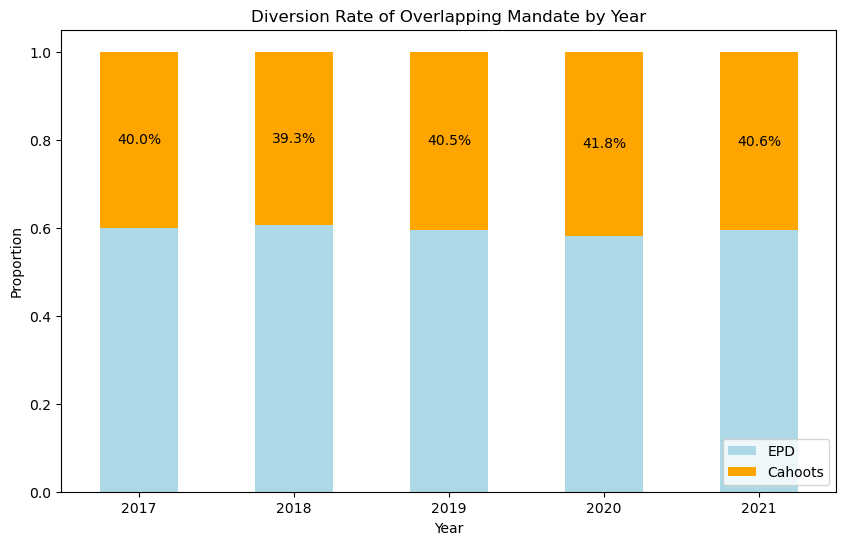

In [21]:
import matplotlib.pyplot as plt

CAD_data_diversions_filtered = overlap_diversions[
    overlap_diversions['Call_Created_Time'].dt.year.isin([2017, 2018, 2019, 2020, 2021])
]

# Group by year and whether it was Handled by Cahoots, then count occurrences
yearly_data_diversions = CAD_data_diversions_filtered.groupby(
    [CAD_data_diversions_filtered['Call_Created_Time'].dt.year, 'Cahoots_related']
).size().unstack(fill_value=0)

# Calculate proportions of calls handled by Cahoots vs Police by dividing by the row sum
yearly_data_prop_diversions = yearly_data_diversions.div(yearly_data_diversions.sum(axis=1), axis=0)

# Plotting
ax = yearly_data_prop_diversions.plot(kind='bar', stacked=True, color=['lightblue', 'orange'], figsize=(10, 6))

# Add labels to the bars
for i in range(yearly_data_prop_diversions.shape[0]):  
    cahoots_proportion = yearly_data_prop_diversions.iloc[i, 1]  # Proportion handled by Cahoots
    if cahoots_proportion > 0:  
        ax.text(i, yearly_data_prop_diversions.iloc[i, 0] + cahoots_proportion / 2,
                f'{cahoots_proportion:.1%}', ha='center', va='center', fontsize=10, color='black')

# Plot settings
plt.title('Diversion Rate of Overlapping Mandate by Year')
plt.xlabel('Year')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(['EPD', 'Cahoots'], loc='lower right')

plt.show()

Looking only at our identified areas of overlapping mandate we get a diversion rate from around 40-43%. The yearly trend in Diversion Rates closely follows our plot our from the previous section, holding relatively constant but increasing over time. This diversion rate also offers insight into the future scalability of the Cahoots model. Since we are only looking at areas of overlapping mandate, this tells how many calls cahoots is diverting from traditional law enforcement out of the total calls they could potentially divert. Since Cahoots cannot respond to all call types, there is a theoretical maximum that Cahoots can expand services, past which diverting more calls from EPD would not be possible. Our results suggest that even with significant expansion, Cahoots would be hard pressed to run out of divertible calls, indicating that an expansion in Cahoots services would likely continue yielding substantial cost savings for traditional law enforcement. 

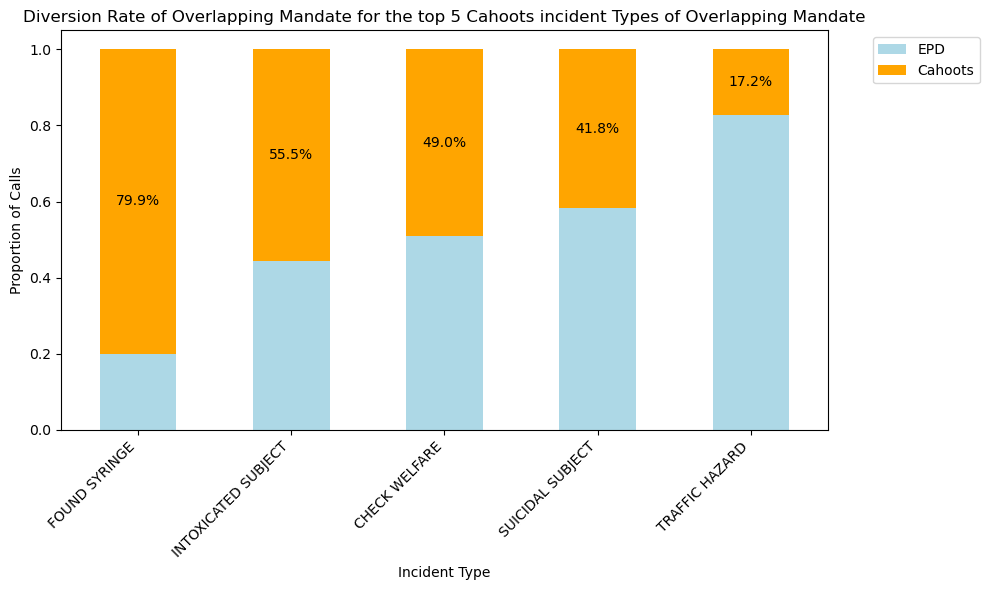

In [22]:
top_5_incidents = CAD_data_diversions_filtered[(CAD_data_diversions_filtered["PrimaryUnitCallSign"] == "CAHOOT") & (CAD_data_diversions_filtered["IsPrimary"] == 1)]["InitialIncidentTypeDescription"].value_counts().nlargest(5).index
#top_5_incidents = CAD_data_diversions_filtered[CAD_data_diversions_filtered["Cahoots_related"] == 1]["InitialIncidentTypeDescription"].value_counts().nlargest(5).index


CAD_data_diversions_filtered_top_5 = CAD_data_diversions_filtered[CAD_data_diversions_filtered["InitialIncidentTypeDescription"].isin(top_5_incidents)]

incident_data = CAD_data_diversions_filtered_top_5.groupby(['InitialIncidentTypeDescription', 'Cahoots_related']).size().unstack(fill_value=0)
incident_data_prop = incident_data.div(incident_data.sum(axis=1), axis=0)

incident_data_sorted = incident_data_prop.sort_values(by=1, ascending=False)
ax = incident_data_sorted.plot(kind='bar', stacked=True, color=['lightblue', 'orange'], figsize=(10, 6))

# Add labels to the Cahoots portion of the bars
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if p.get_facecolor() == ax.patches[-1].get_facecolor() and height > 0: 
        ax.text(x + width / 2, y + height / 2, f'{height:.1%}', ha='center', va='center', fontsize=10)

plt.title('Diversion Rate of Overlapping Mandate for the top 5 Cahoots incident Types of Overlapping Mandate')
plt.xlabel('Incident Type')
plt.ylabel('Proportion of Calls')
plt.xticks(rotation=45, ha='right')
plt.legend(['EPD', 'Cahoots'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Breaking down the diversion Rate by call type, we can see that the potential for Cahoots expansion is not uniform across call types. For example, Cahoots is already handling 80% of found syringe calls. It should also be said that Cahoots is not necessarily eligible for dispatch to all of these calls and many of these call may not exist without Cahoots. Looking at the divertibility measures from our natural experiment is a good basis for measuring extra calls created by cahoots, but that does not tell us the proportion of calls Cahoots would be allowed to handle. As of right now, I have been unable to derive a reliable proxy for this measure. Future work should look at some way to quantify the proportion of each call type that is Cahoots eligible. 

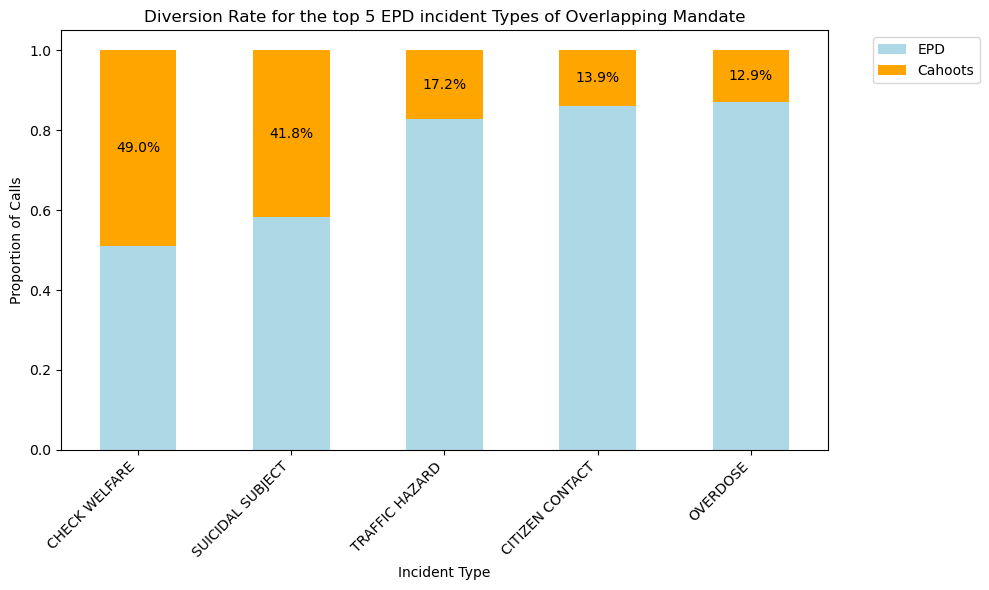

In [23]:
#top_5_incidents = CAD_data_diversions_filtered[(CAD_data_diversions_filtered["PrimaryUnitCallSign"] != "CAHOOT") & (CAD_data_diversions_filtered["IsPrimary"] == 1)]["InitialIncidentTypeDescription"].value_counts().nlargest(5).index
top_5_incidents = CAD_data_diversions_filtered[CAD_data_diversions_filtered["Cahoots_related"] == 0]["InitialIncidentTypeDescription"].value_counts().nlargest(5).index


CAD_data_diversions_filtered_top_5 = CAD_data_diversions_filtered[CAD_data_diversions_filtered["InitialIncidentTypeDescription"].isin(top_5_incidents)]

incident_data = CAD_data_diversions_filtered_top_5.groupby(['InitialIncidentTypeDescription', 'Cahoots_related']).size().unstack(fill_value=0)
incident_data_prop = incident_data.div(incident_data.sum(axis=1), axis=0)

incident_data_sorted = incident_data_prop.sort_values(by=1, ascending=False)
ax = incident_data_sorted.plot(kind='bar', stacked=True, color=['lightblue', 'orange'], figsize=(10, 6))

# Add labels to the Cahoots portion of the bars
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if p.get_facecolor() == ax.patches[-1].get_facecolor() and height > 0: 
        ax.text(x + width / 2, y + height / 2, f'{height:.1%}', ha='center', va='center', fontsize=10)

plt.title('Diversion Rate for the top 5 EPD incident Types of Overlapping Mandate')
plt.xlabel('Incident Type')
plt.ylabel('Proportion of Calls')
plt.xticks(rotation=45, ha='right')
plt.legend(['EPD', 'Cahoots'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Looking at the top EPD call types of overlapping mandate, we see similar results. Welfare check, traffic hazard and suicidal subject make a repeat appearance but we now also see overdose and citizen contact. These areas represent potentially large opportunities for Cahoots expansion but we fall short from conclusive recommendations without a way to confirm if a call is Cahoots eligible. 

## Discussion

Most effort should be placed on identifying which individual calls had conditions suitable for Cahoots intervention. 

Sources

17-20%

https://www.usnews.com/news/cities/articles/2020-07-06/eugene-oregons-30-year-experiment-with-reimagining-public-safety

https://whitebirdclinic.org/wp-content/uploads/2020/06/CAHOOTS-Media-Guide-20200626.pdf



NOTE: FIX THE SUBSET DROP, MOVE TO DATA CLEANING INSTEAD OF REPLICATION

NOTE: Fix data table examples to include the correct features 

Other Cahoots info:

https://www.scribd.com/document/480759696/CAHOOTS-Call-Taking-Manual-pdf

https://lawenforcementactionpartnership.org/wp-content/uploads/2023/06/CAHOOTS-procedure.pdf

https://www.eugene-or.gov/DocumentCenter/View/530/Police-Call-Priority-Definitions


The EPD's own Cahoots procedure manual outlines situations where Cahoots cannot handle the these call types so they clearly know that these incident types are not completely non divertible

Important assumption about composite method: This assumes that an incident type is either divertible or non divertible, it does not account for some incident types being partially divertible. Future work should include the proportional inclusion of call types based on how much of a type is likely divertible 

NOTE THAT FINAL DIVERSION RATES ARE NOT COMPARABLE